# Data insight

In [1]:
from app.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

RANDOM_SEED = 40

np.random.seed(RANDOM_SEED)

In [2]:
dataset, labels = load_dataset("./dataset/train")

label_to_category = {}
with open("./dataset/labels.txt", "r") as f:
    for line in f.readlines():
        if line != "\n":
            label, category = line.split(":")
            label_to_category[int(label)] = category.strip(" \n")

info = []
for img, label in zip(dataset, labels):
    info.append([label, label_to_category[label], img.shape[0], img.shape[1]])
    
df = pd.DataFrame(info, columns=["label", "category", "width", "height"])
df


,label,category,width,height
0,16,arbre,168,219
1,34,chien,156,163
2,28,goutte,109,158
3,20,petit bonhomme,229,135
4,40,coccinelle,242,256
...,...,...,...,...
280,53,soleil,289,304
281,27,cactus,398,278
282,49,chaton,339,295
283,14,carotte,326,203


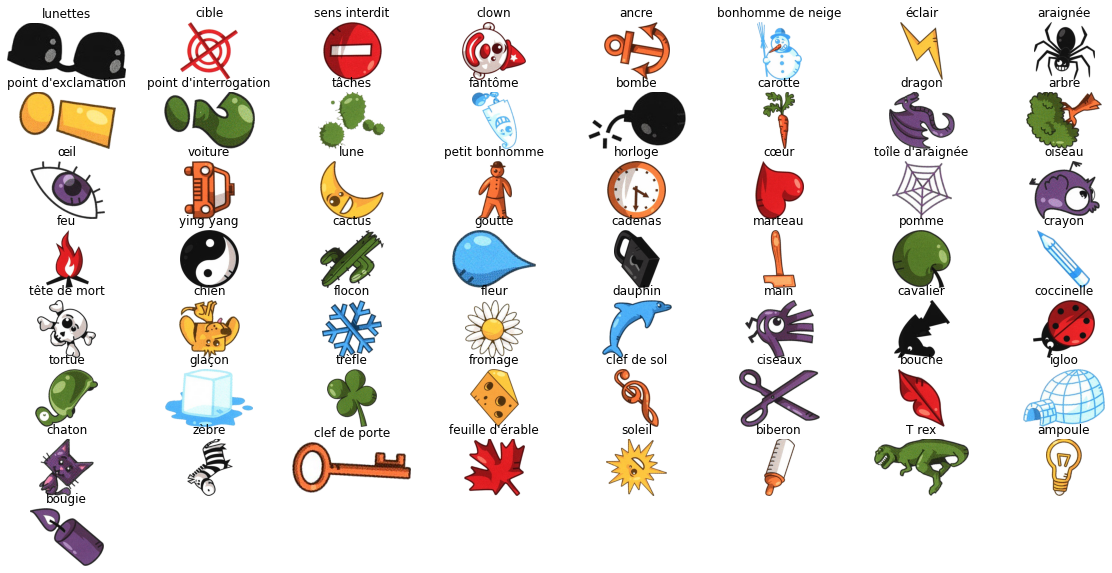

In [3]:
# Different colors + rotation are performed
plt.figure(figsize=(20,10))

for i in range(1, len(label_to_category) + 1):
    plt.subplot(8, 8, i)
    plt.title(label_to_category[i])
    idx = np.where(np.array(labels) == i)[0][0]
    plt.imshow(dataset[idx])
    plt.axis('off')

plt.show()

In [4]:
# Few samples per class => need for data augmentation
df.groupby("category").count()["label"]

category
T rex                    5
ampoule                  5
ancre                    5
araignée                 5
arbre                    5
biberon                  5
bombe                    5
bonhomme de neige        5
bouche                   5
bougie                   5
cactus                   5
cadenas                  5
carotte                  5
cavalier                 5
chaton                   5
chien                    5
cible                    5
ciseaux                  5
clef de porte            5
clef de sol              5
clown                    5
coccinelle               5
crayon                   5
cœur                     5
dauphin                  5
dragon                   5
fantôme                  5
feu                      5
feuille d'érable         5
fleur                    5
flocon                   5
fromage                  5
glaçon                   5
goutte                   5
horloge                  5
igloo                    5
lune               

In [5]:
# Different shape => may need to reshape all of it ? 
df.describe()

,label,width,height
count,285.000000,285.000000,285.000000
mean,29.000000,199.691228,194.575439
std,16.480889,59.894944,56.456877
min,1.000000,71.000000,80.000000
25%,15.000000,157.000000,155.000000
50%,29.000000,195.000000,192.000000
75%,43.000000,236.000000,225.000000
max,57.000000,398.000000,418.000000


In [6]:
tmp_dataset_aug, tmp_labels_aug = dataset_augmentation([dataset[3]], [labels[3]], transformation_per_image=1)

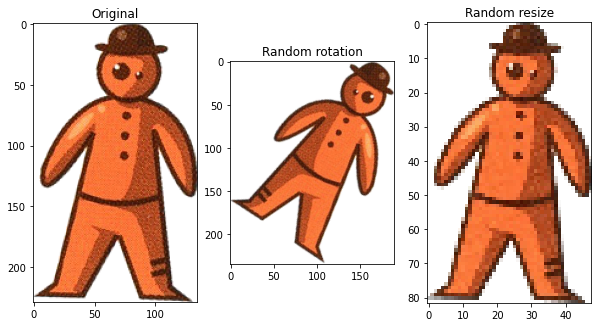

In [7]:
# Different colors + rotation are performed
plt.figure(figsize=(10,10))

plt.subplot(1, 3, 1)
plt.imshow(tmp_dataset_aug[0])
plt.title("Original")
plt.subplot(1, 3, 2)
plt.title("Random rotation")
plt.imshow(tmp_dataset_aug[1])
plt.subplot(1, 3, 3)
plt.title("Random resize")
plt.imshow(tmp_dataset_aug[2])

plt.show()

train_test_split()

In [8]:
from sklearn.model_selection import train_test_split

print(f"Original dataset = {len(dataset)}")
img_train, img_test, label_train, label_test = train_test_split(dataset, labels, test_size=0.2, random_state=RANDOM_SEED, stratify=labels)
print(f"Train size = {len(img_train)} / Test size = {len(img_test)}")
print(f"Train size augmented = {len(img_train)} / Test size augmented = {len(img_test)}")
dataset_aug, labels_aug = dataset_augmentation(img_train, label_train, transformation_per_image=1)

Original dataset = 285
Train size = 228 / Test size = 57
Train size augmented = 228 / Test size augmented = 57


# Feature extraction

To make our pipeline work, we need to transform raw image data into numerical features that can be processed by a classifier. Since our dataset contains image that have different size, rotation and noise, those features need to be invariant to those transformation and keep a low dimensionality to be fast enough to process.

We will split this feature extraction step in two parts: color extraction & shape extraction.

## Color extraction

In this step, we will try to express our image as an histogram of common colors we see in our dataset. To do this, we need to indentify those colors.

In [9]:
img_train, img_test, label_train, label_test = train_test_split(dataset, labels, test_size=0.2, random_state=RANDOM_SEED, stratify=labels)

In our dataset, images are surrounded by a white background. Since the proportion of this background vary with the rotation of the image, we need to eliminate it as it may bias our color extraction. For this, we will create a mask for each image.

In [10]:
def create_mask(img):
    selector = (img[...,0] == 255) & (img[...,1] == 255) & (img[...,2] == 255)
    return ~selector

mask_train = [create_mask(img) for img in img_train]

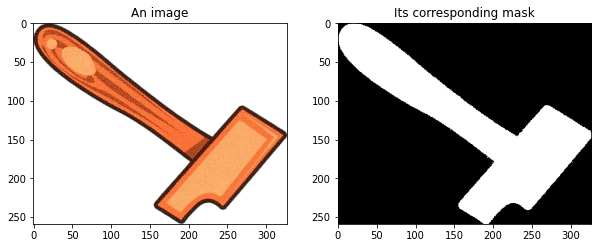

In [11]:
# Plot img & its corresponding mask
fx, plots = plt.subplots(1, 2, figsize=(10,5))
plots[0].set_title("An image")
plots[0].imshow(img_train[0])
plots[1].set_title("Its corresponding mask")
plots[1].imshow(mask_train[0], cmap='gray')
plt.show()

### Creating a color palette

To create a color palette we will first extract samples of pixels from each image, and aggregate them in what we call a "super sample".

In [12]:
samples = []
for (i, img) in enumerate(img_train):
    img_masked = img[mask_train[i]]
    indices = np.random.choice(img_masked.shape[0], 50, replace=False)
    sample = img_masked[indices]

    samples.append(sample)

super_sample = np.vstack(samples)

Unique colors: 8692


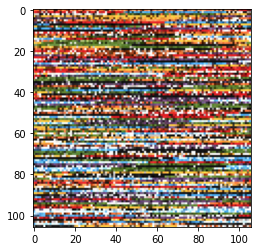

In [13]:
# Display super sample
from math import sqrt
side = int(sqrt(float(super_sample.shape[0])))
plt.imshow(super_sample[:(side * side)].reshape((side, side, 3)))

# Count unique colors
print(f'Unique colors: {np.unique(super_sample, axis=0).shape[0]}')

As you can see, our super sample contains a lot of different colors. If we were to express our color features using all these colors, the dimensionality would be way too high. To reduce this set, we will quantize the super sample using the K-mean algorithm.

In [14]:
from sklearn.cluster import KMeans

kmean_color = KMeans(n_clusters=24, random_state=RANDOM_SEED)
kmean_color.fit(super_sample)
color_lut = np.uint8(kmean_color.cluster_centers_)

To find a good color palette, we need to determine a good amount a colors. Let's compare them.

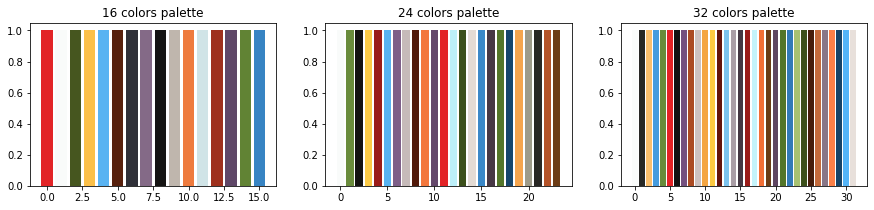

In [15]:
# Plot img & its corresponding mask
fx, plots = plt.subplots(1, 3, figsize=(15,3))

for i, count in enumerate([16, 24, 32]):
    kmean = KMeans(n_clusters=count, random_state=RANDOM_SEED)
    kmean.fit(super_sample)
    lut = np.uint8(kmean.cluster_centers_)

    plots[i].set_title(f"{count} colors palette")
    plots[i].bar(np.arange(len(lut)), np.ones(len(lut)), color=lut/255)
plt.show()

As you can see, in the 32 colors palette, some colors a repeated and some are missing in the 16 colors palette. The 24 colors palette seems to be a good fit.

### Extracting color features using our palette

Now that our palette is created, we will use it to reconstruct our image.

In [16]:
label_maps = []
for img, mask in zip(img_train, mask_train):
    lm = kmean_color.predict(img[mask])
    label_maps.append(lm)

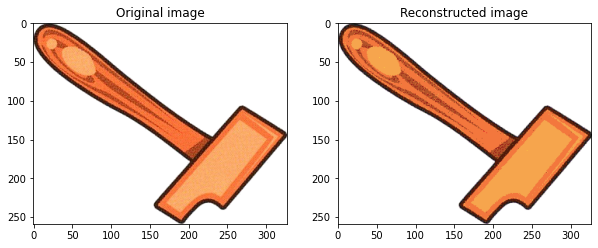

In [17]:
recolored_img = np.ones(img_train[0].shape, dtype=np.uint8) * 255
recolored_img[mask_train[0]] = color_lut[label_maps[0]]

fx, plots = plt.subplots(1, 2, figsize=(10,5))
plots[0].set_title("Original image")
plots[0].imshow(img_train[0])
plots[1].set_title("Reconstructed image")
plots[1].imshow(recolored_img)
plt.show()

As you can see, the reconstructed image is very similar to our original image. Let's now build an histogram using our palette.

In [18]:
# Extract histogram (use minlength to ensure homogeneous dimensionality)
histograms = np.array([np.bincount(lm, minlength=len(
        kmean_color.cluster_centers_)) / len(lm) for lm in label_maps], dtype=np.float64)

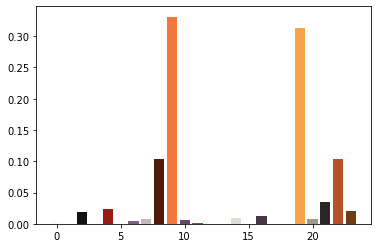

In [19]:
plt.bar(np.arange(len(color_lut)), 
         histograms[0], 
         color=color_lut/255)
plt.show()

The color histogram is now ready, we can use it to describe the color features of our image.

## Shape extraction

We now have an descriptor that can extract the colors of an image. We will now try to extract informations about the shape. 

For this purpose, we will try to use two different shape extraction technique, the first one using Hu Moments, and the second using ORB algorithm.

### Hu Moments

Hu Moments are a set of 7 numbers calculated using central moments that are invariant to image transformations. They are normally extracted from the silhouette or outline of an object in an image. Will try to compute a clean and normalized outline of an image.

First, we will remove the color of our image.

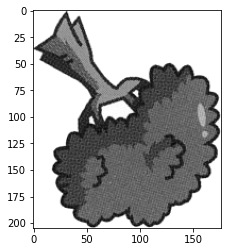

In [20]:
import cv2

gray_img = cv2.cvtColor(img_train[5], cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img, cmap='gray')
plt.show()

To compute the outline of an image we will use this pipeline:
- Add borders and padding to ensure the image is square, and not too close from the edges
- Blur the image, to remove any noise
- Binarize the image using Otsu thresholding
- Compute the contour using Canny algorithm

You can see the different steps below.

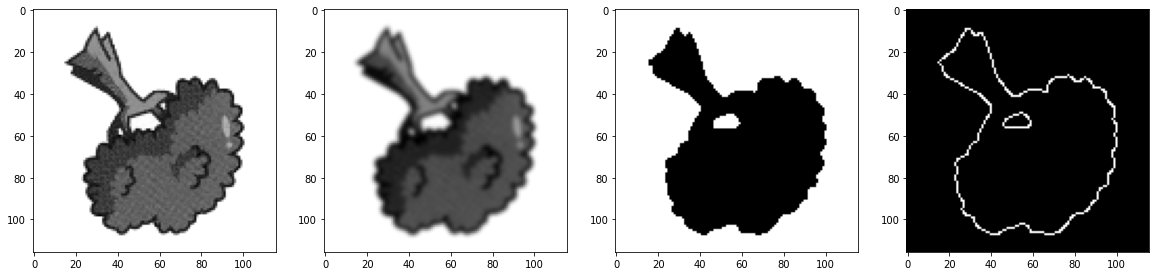

In [21]:
height, width = gray_img.shape
if height > width:
    square_img = cv2.copyMakeBorder(gray_img, 0, 0, (height - width) // 2, (height - width) // 2, cv2.BORDER_CONSTANT, value=255)
elif width > height:
    square_img = cv2.copyMakeBorder(gray_img, (width - height) // 2, (width - height) // 2, 0, 0,  cv2.BORDER_CONSTANT, value=255)

resized_img = cv2.resize(square_img, (100, 100))
padded_img = cv2.copyMakeBorder(resized_img, 8, 8, 8, 8, cv2.BORDER_CONSTANT, value=255)

fx, plots = plt.subplots(1, 4, figsize=(20,5))

plots[0].imshow(padded_img, cmap='gray')

blurred_img = cv2.GaussianBlur(padded_img, (5, 5), 0)
plots[1].imshow(blurred_img, cmap='gray')

_, binary_img = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plots[2].imshow(binary_img, cmap='gray')

canny_img = cv2.Canny(binary_img, 100, 200)
plots[3].imshow(canny_img, cmap='gray')

plt.show()

We can now compute Hu Moments of our outline using OpenCV.

In [22]:
moments = cv2.moments(canny_img)
hu_moments = cv2.HuMoments(moments).flatten()
hu_moments

array([ 1.55150504e-02,  1.22243388e-05,  4.78557538e-07,  4.74015942e-08,
       -3.51614433e-15,  1.51332093e-10,  6.21341595e-15])

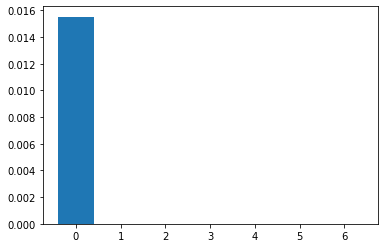

In [23]:
plt.bar(np.arange(len(hu_moments)), hu_moments)
plt.show()

As you can see, if we plot our moments, one of the feature stands out and is much higher than the others in comparision. Let's apply logarithmic scale to fix this.

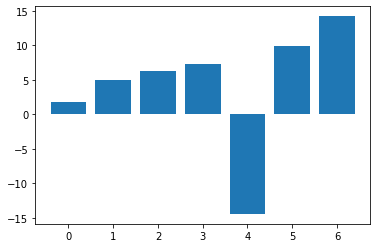

In [24]:
hu_moments_log = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
plt.bar(np.arange(len(hu_moments_log)), hu_moments_log)
plt.show()

The moments descriptor is now ready, we can use it to describe the shape of our image.

### Orb

- To extract shape feature, we will use the Oriented FAST and Rotated BRIEF (ORB) which is basically a fusion of:
    - FAST (Features from Accelerated Segment Test) for keypoints detector => **Scale invariant**
    - rBRIEF (Rotation-aware Binary Robust Independent Elementary Features) for descriptors computation => **Rotation invariant**
- On top of being open-source, ORB is said to be faster than its counterparts SIFT and SURF 

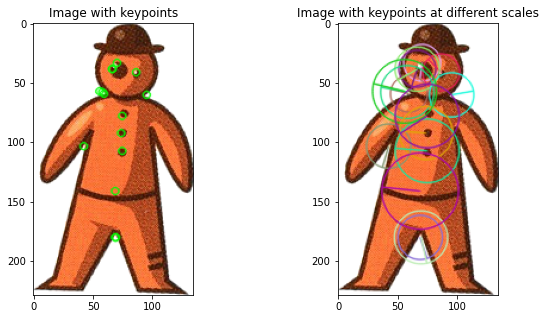

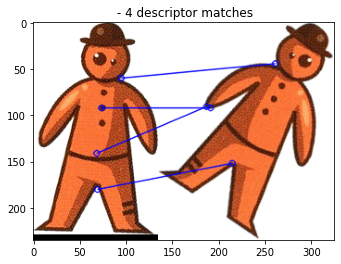

In [25]:
original = tmp_dataset_aug[0]
rotated = tmp_dataset_aug[1] 

orb = cv2.ORB_create(nfeatures=20, scaleFactor=1.2)

# Detect keypoints of original image
(kp1,des1) = orb.detectAndCompute(original, None)

# Display keypoints with/without size & orientation
kp1_without_size = np.copy(original)
kp1_with_size = np.copy(original)
cv2.drawKeypoints(original, kp1, kp1_without_size, color = (0, 255, 0))
cv2.drawKeypoints(original, kp1, kp1_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fx, plots = plt.subplots(1, 2, figsize=(10,5))
plots[0].set_title("Image with keypoints")
plots[0].imshow(kp1_without_size, cmap='gray')
plots[1].set_title("Image with keypoints at different scales")
plots[1].imshow(kp1_with_size, cmap='gray')

# Detect keypoints of rotated image
(kp2,des2) = orb.detectAndCompute(rotated, None)

# Create matcher to show that descriptors are properly computed
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
bf.add([des1,des2])
matches = bf.match(des1,des2)

def draw_matches(img1, kpts1, img2, kpts2, matches, color=(0,0,255), title=""):
    '''img1 and img2 are color images.'''
    img_matches = np.empty((max(img1.shape[0], img2.shape[0]),
                           img1.shape[1]+img2.shape[1], 
                           3), 
                           dtype=np.uint8)
    img_matches = cv2.drawMatches(img1, kpts1, img2, kpts2, 
                          matches, 
                          img_matches,
                          matchColor=color,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12,4))
    plt.imshow(img_matches)
    plt.title(title + " - %d descriptor matches" % (len(matches),))

draw_matches(original, kp1, rotated, kp2, matches)

# Model evaluation

In [26]:
%cd app/

from app.main import load_dataset, train_test_split, dataset_augmentation, feature_extractor, LOAD_SESSION, RANDOM_SEED, PONDERATION
from app.fusion import train, evaluate
from app.visualization import plot_confusion_matrix
import numpy as np

%cd ..

/home/bouteille/Documents/iml-project/app
/home/bouteille/Documents/iml-project


- To evaluate our model, we decided to choose accuracy as a metric
- Confusion matrix were plotted to diagnostic our classifiers

## Dummy classifier

- To sanity check our pipeline, we trained a dummy classifier. It should predict 1/57 = 0.0175438596

In [27]:
print('Loading dataset...')
dataset, labels = load_dataset("./dataset/train")

img_train, img_test, label_train, label_test = train_test_split(
    dataset, labels, test_size=0.2, random_state=RANDOM_SEED, stratify=labels)

print('Dataset augmentation...')
dataset_aug, labels_aug = dataset_augmentation(dataset, labels, transformation_per_image=1)

print("Create feature extractor ...\n")
color_feature_extractor, shape_feature_extractor = feature_extractor(
    img_train, load_session=LOAD_SESSION, mode="moments")

Loading dataset...
Dataset augmentation...
Create feature extractor ...

Mode Hu moments ...


In [28]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier() 
train(clf, color_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, color_feature_extractor(img_test), label_test)
print(accuracy)

0.017543859649122806


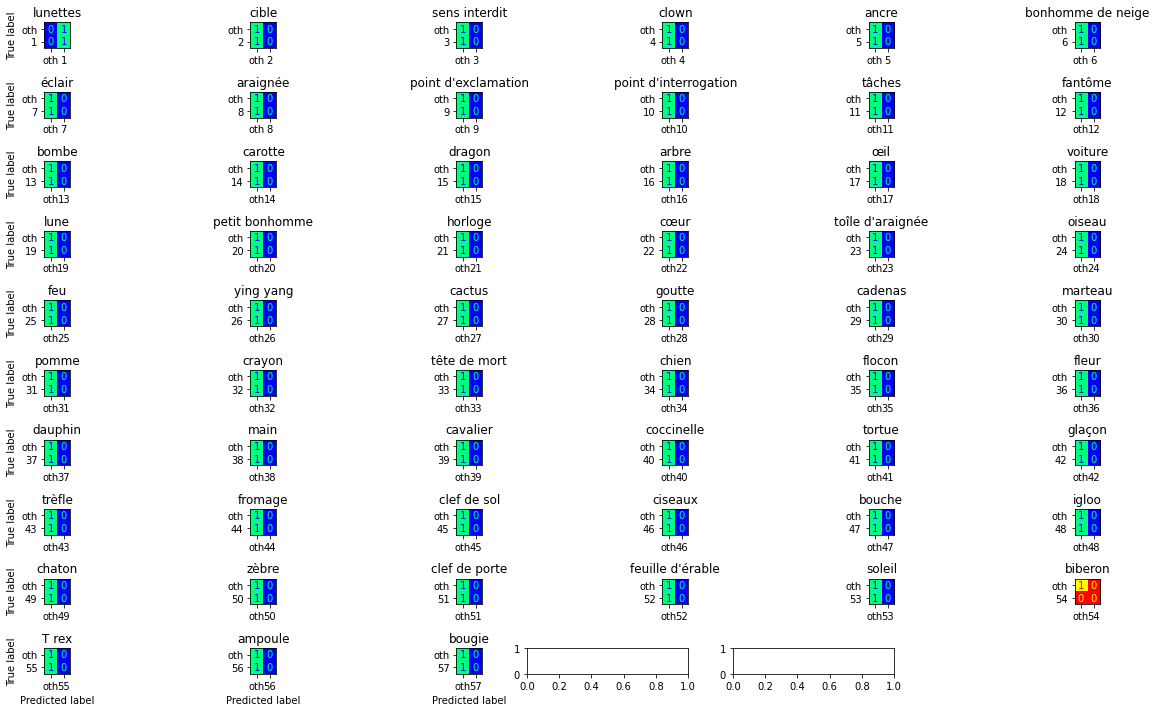

In [29]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

## Train Color descriptor alone

In [30]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5)

In [31]:
train(clf, color_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, color_feature_extractor(img_test), label_test)
print(accuracy)

0.9473684210526315


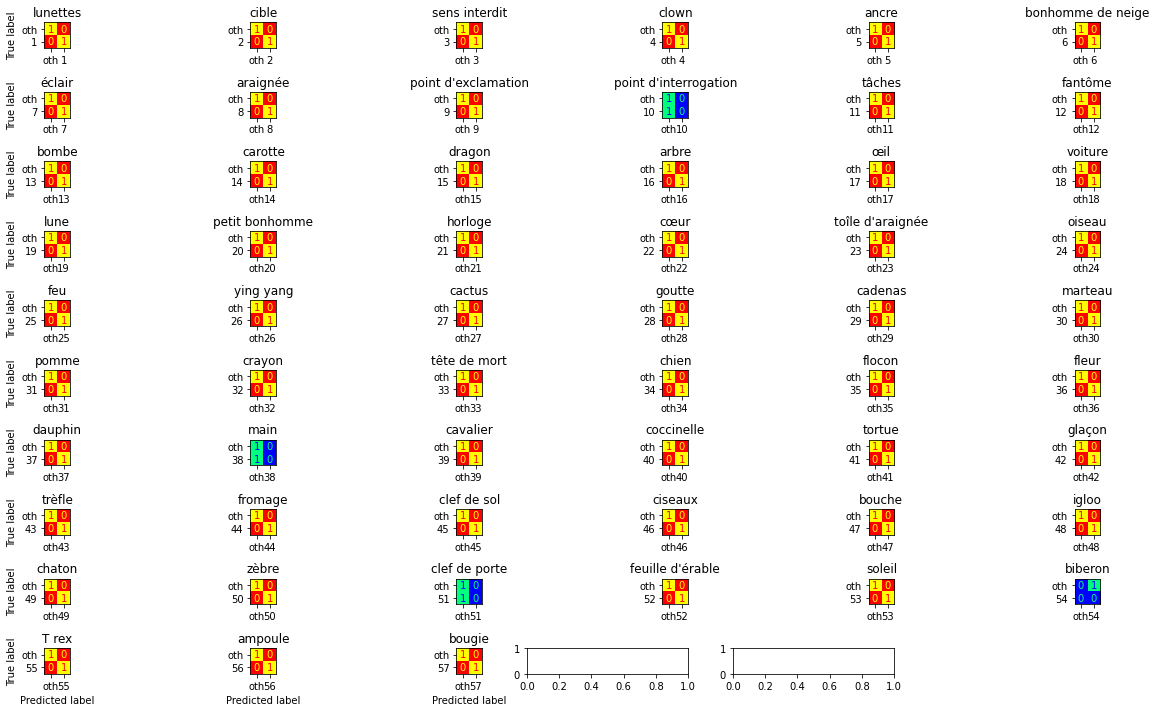

In [32]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

# Train Shape descriptor

- Hu moments

In [33]:
clf = RandomForestClassifier(max_depth=5)
_, shape_feature_extractor = feature_extractor(img_train, load_session=LOAD_SESSION, mode="moments")

Mode Hu moments ...


In [34]:
train(clf, shape_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, shape_feature_extractor(img_test), label_test)
print(accuracy)

0.8947368421052632


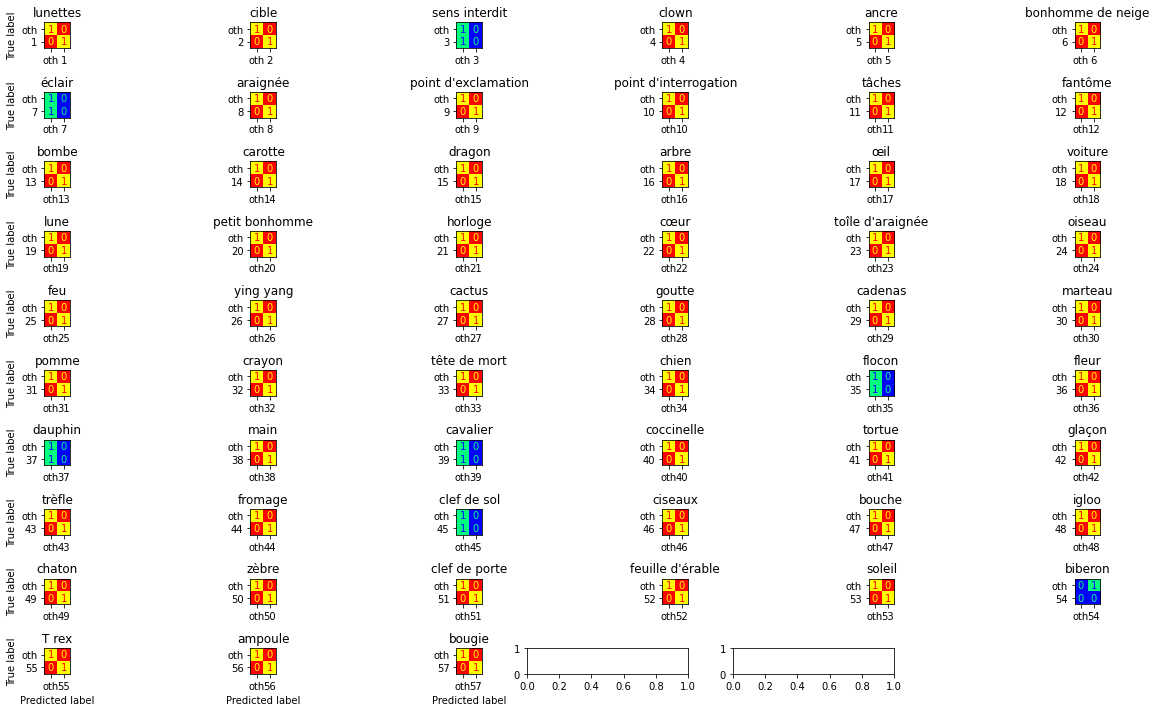

In [35]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

- ORB

In [36]:
clf = RandomForestClassifier(max_depth=8)
_, shape_feature_extractor = feature_extractor(img_train, load_session=LOAD_SESSION, mode="orb")

Mode ORB ...


In [ ]:
train(clf, shape_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, shape_feature_extractor(img_test), label_test)
print(accuracy)

0.9090909090909091


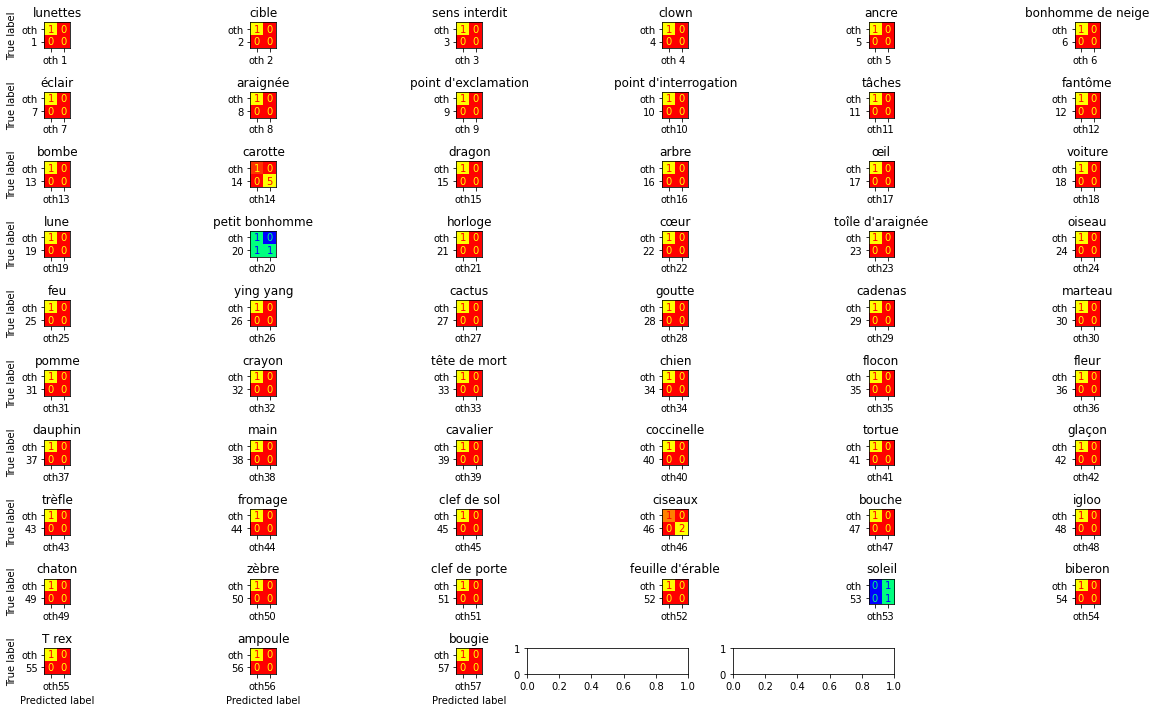

In [ ]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

# Train color descriptor + Shape descriptor (Hu moment)

Early fusion

In [ ]:
clf = RandomForestClassifier(max_depth=5)

In [ ]:
color_feature_extractor, shape_feature_extractor = feature_extractor(img_train, load_session=LOAD_SESSION, mode="moments")

def feature_extractor_fusion(color_feature_extractor, shape_feature_extractor):
    return lambda img: np.hstack((color_feature_extractor(img) * PONDERATION, shape_feature_extractor(img) * (1 - PONDERATION)))

fused_feature_extractor = feature_extractor_fusion(
        color_feature_extractor, shape_feature_extractor)

feature_train = fused_feature_extractor(img_train)
feature_test = fused_feature_extractor(img_test)

Mode Hu moments ...


In [ ]:
train(clf, feature_train, label_train)
prediction, accuracy = evaluate(clf, feature_test, label_test)
print(accuracy)

1.0


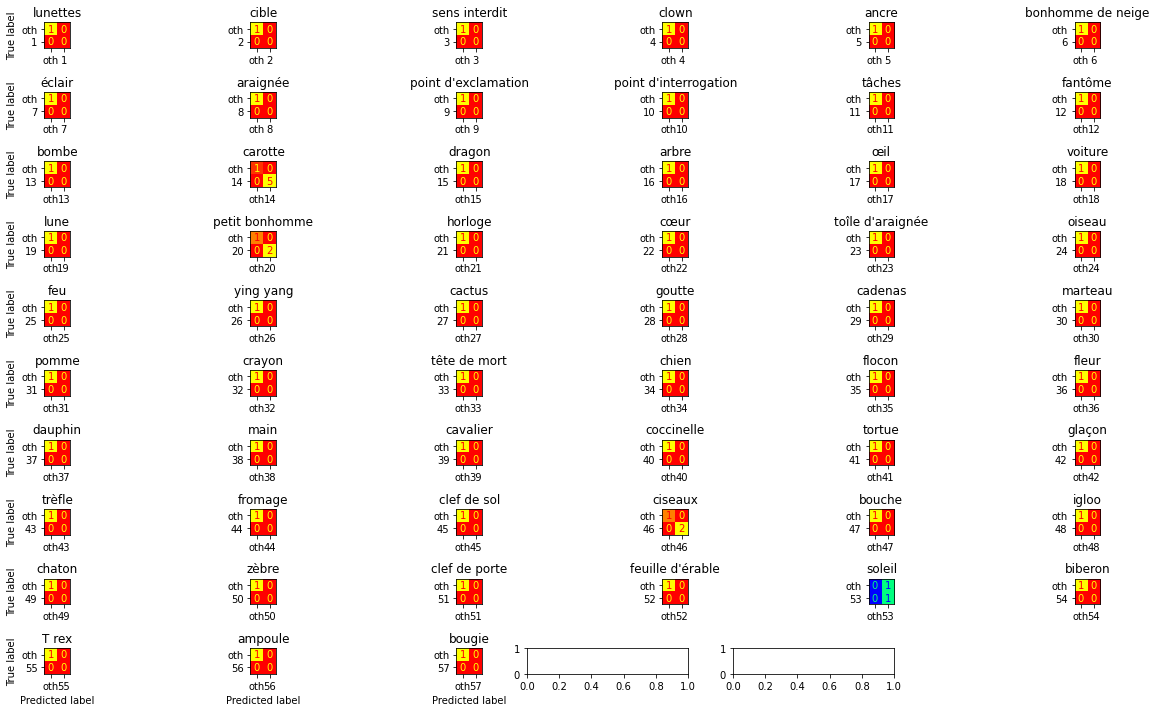

In [ ]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

Late fusion

In [ ]:
clf_0 = RandomForestClassifier(max_depth=3)
clf_1 = RandomForestClassifier(max_depth=5)

In [ ]:
color_feature_train = color_feature_extractor(img_train)
shape_feature_train = shape_feature_extractor(img_train)

color_feature_test = color_feature_extractor(img_test)
shape_feature_test = shape_feature_extractor(img_test)

train(clf_0, color_feature_train, label_train)
train(clf_1, shape_feature_train, label_train)

In [ ]:
def soft_voting(color_predict_proba, shape_predict_proba):
    def get_max_proba_indices(color_predict_proba, shape_predict_proba):
        classes_pred_proba = 0.6 * color_predict_proba + 0.4 * shape_predict_proba
        return np.argmax(classes_pred_proba, axis=1)

    max_proba_indces = get_max_proba_indices(
        color_predict_proba, shape_predict_proba)
    
    return max_proba_indces + 1


color_labels = clf_0.predict(color_feature_test)
shape_labels = clf_1.predict(shape_feature_test)

prediction = soft_voting(clf_0.predict_proba(color_feature_test), clf_1.predict_proba(shape_feature_test))
accuracy = np.sum(np.array(prediction) ==np.array(label_test)) / len(prediction)
print(accuracy)

0.0


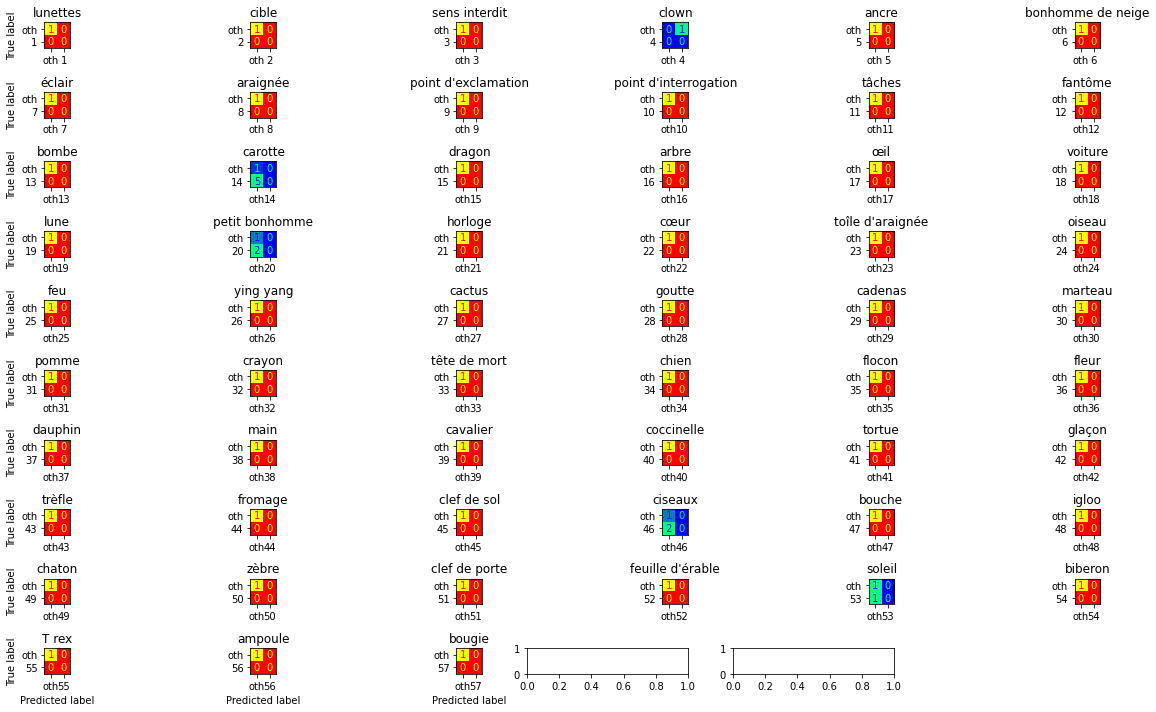

In [ ]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

# Model benchmark

#### Goals

Compare accuracy of color descriptor and Hu-moments over:
   - different data augmentation
   - different fusion (early, late, stacking-early and stacking-late)

### Benchmark

|                 | Type de fusions | Classifiers utilisés          | Temps d'execution (s) | Meilleur accuracy (%) | Autres accuracy (%) |
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Early           | Knn                           | 26,403                | 100                   | 95,41               |
|                 |                 | SVM linear                    |                       |                       | 98,83               |
|                 |                 | SVM poly                      |                       |                       | 31,50               |
|                 |                 | SVM rbf                       |                       |                       | 12,30               |
|                 |                 | Random forest                 |                       |                       | 100                 |
|                 |                 | Decision tree                 |                       |                       | 99,75               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|  Data aug = 10  | Late            | Knn - Knn                     | 68,033                | 100                   | 100                 |
|     CV = 40     |                 | Knn - Random forest           |                       |                       | 100                 |
|                 |                 | Knn - Decision tree           |                       |                       | 99,92               |
|                 |                 | Random forest - Random forest |                       |                       | 100                 |
|                 |                 | Random forest - Knn           |                       |                       | 96,41               |
|                 |                 | Random forest - Decision tree |                       |                       | 99,16               |
|                 |                 | Decision tree - Decision tree |                       |                       | 99,67               |
|                 |                 | Decision tree - Knn           |                       |                       | 99,67               |
|                 |                 | Decision tree - Random forest |                       |                       | 99,33               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking early  | Decision tree + Random forest | 91,98                 | 100                   | 99,67               |
|                 |                 | Decision tree + pipeline      |                       |                       | 100                 |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking late   | Decision tree + Random forest | 53,77                 | 100                   | 100                 |
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Early           | Knn                           | 12,88                 | 100                   | 92,5                |
|                 |                 | SVM linear                    |                       |                       | 98,41               |
|                 |                 | SVM poly                      |                       |                       | 23,12               |
|                 |                 | SVM rbf                       |                       |                       | 15,16               |
|                 |                 | Random forest                 |                       |                       | 100                 |
|                 |                 | Decision tree                 |                       |                       | 99,51               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|  Data aug = 5   | Late            | Knn - Knn                     | 33,977                | 100                   | 99,84               |
|     CV = 40     |                 | Knn - Random forest           |                       |                       | 100                 |
|                 |                 | Knn - Decision tree           |                       |                       | 100                 |
|                 |                 | Random forest - Random forest |                       |                       | 100                 |
|                 |                 | Random forest - Knn           |                       |                       | 95,06               |
|                 |                 | Random forest - Decision tree |                       |                       | 96,49               |
|                 |                 | Decision tree - Decision tree |                       |                       | 99,68               |
|                 |                 | Decision tree - Knn           |                       |                       | 99,52               |
|                 |                 | Decision tree - Random forest |                       |                       | 99,68               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking early  | Decision tree + Random forest | 46,344                | 100                   | 99,36               |
|                 |                 | Decision tree + pipeline      |                       |                       | 100                 |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking late   | Decision tree + Random forest | 23,348                | 99,84                 | 99,84               |
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Early           | Knn                           | 5,185                 | 100                   | 80,7                |
|                 |                 | SVM linear                    |                       |                       | 84,21               |
|                 |                 | SVM poly                      |                       |                       | 12,28               |
|                 |                 | SVM rbf                       |                       |                       | 16,37               |
|                 |                 | Random forest                 |                       |                       | 100                 |
|                 |                 | Decision tree                 |                       |                       | 97,08               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|  Data aug = 1   | Late            | Knn - Knn                     | 14,97                 | 100                   | 99,42               |
|     CV = 12     |                 | Knn - Random forest           |                       |                       | 99,42               |
|                 |                 | Knn - Decision tree           |                       |                       | 99,42               |
|                 |                 | Random forest - Random forest |                       |                       | 100                 |
|                 |                 | Random forest - Knn           |                       |                       | 91,23               |
|                 |                 | Random forest - Decision tree |                       |                       | 94,15               |
|                 |                 | Decision tree - Decision tree |                       |                       | 98,25               |
|                 |                 | Decision tree - Knn           |                       |                       | 95,32               |
|                 |                 | Decision tree - Random forest |                       |                       | 95,91               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking early  | Decision tree + Random forest | 10,128                | 100                   | 98,83               |
|                 |                 | Decision tree + pipeline      |                       |                       | 100                 |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking late   | Decision tree + Random forest | 8,291                 | 100                   | 100                 |
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Early           | Knn                           | 4,648                 | 100                   | 80,7                |
|                 |                 | SVM linear                    |                       |                       | 84,21               |
|                 |                 | SVM poly                      |                       |                       | 12,28               |
|                 |                 | SVM rbf                       |                       |                       | 16,37               |
|                 |                 | Random forest                 |                       |                       | 100                 |
|                 |                 | Decision tree                 |                       |                       | 97,08               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|  Data aug = 1   | Late            | Knn - Knn                     | 10,124                | 100                   | 99,42               |
|     CV = 5      |                 | Knn - Random forest           |                       |                       | 99,42               |
|                 |                 | Knn - Decision tree           |                       |                       | 99,42               |
|                 |                 | Random forest - Random forest |                       |                       | 100                 |
|                 |                 | Random forest - Knn           |                       |                       | 91,23               |
|                 |                 | Random forest - Decision tree |                       |                       | 94,15               |
|                 |                 | Decision tree - Decision tree |                       |                       | 98,25               |
|                 |                 | Decision tree - Knn           |                       |                       | 95,32               |
|                 |                 | Decision tree - Random forest |                       |                       | 95,91               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking early  | Decision tree + Random forest | 6,157                 | 100                   | 98,83               |
|                 |                 | Decision tree + pipeline      |                       |                       | 100                 |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking late   | Decision tree + Random forest | 4,354                 | 100                   | 100                 |
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Early           | Knn                           | 1,657                 | 100                   | 66,67               |
|                 |                 | SVM linear                    |                       |                       | 64,91               |
|                 |                 | SVM poly                      |                       |                       | 42,11               |
|                 |                 | SVM rbf                       |                       |                       | 42,11               |
|                 |                 | Random forest                 |                       |                       | 100                 |
|                 |                 | Decision tree                 |                       |                       | 91,47               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|  Data aug = 0   | Late            | Knn - Knn                     | 5,028                 | 100                   | 94,74               |
|     CV = 4      |                 | Knn - Random forest           |                       |                       | 92,98               |
|                 |                 | Knn - Decision tree           |                       |                       | 92,98               |
|                 |                 | Random forest - Random forest |                       |                       | 100                 |
|                 |                 | Random forest - Knn           |                       |                       | 73,68               |
|                 |                 | Random forest - Decision tree |                       |                       | 80,70               |
|                 |                 | Decision tree - Decision tree |                       |                       | 87,72               |
|                 |                 | Decision tree - Knn           |                       |                       | 89,47               |
|                 |                 | Decision tree - Random forest |                       |                       | 87,72               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking early  | Decision tree + Random forest | 2,418                 | 100                   | 87,72               |
|                 |                 | Decision tree + pipeline      |                       |                       | 100                 |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking late   | Decision tree + Random forest | 2,081                 | 92,98                 | 92,98               |

### Interpretation
Except the execution time, the croos-validation (CV) doesn't seem to have much influence on the results, when there isn't much data augmentation. But the less data we have, the less accuracy different models can achieve.
However the Random forest classifier always has the highest score, it reaches 100% accuracy whether there is data augmentation. Therefore, since early fusion takes the least time to run, it seems to be the best method in our case. So, it doesn't seem to be necessary to apply data augmentation.